# Main document

### Initialization 

In [1]:
import pypsa
import pandas as pd
from BaseNetwork import BuildBaseNetwork

# Task A

In [ ]:

# Basemodel with DK and DE
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
                }

tmp = BuildBaseNetwork(cost_year = 2030, setup = setup, demand_year=2019)

Year 2019 is greater than 2017, using data from last available year.


In [3]:
tmp.network.optimize(solver_name="gurobi",solver_options={"OutputFlag": 0})

Index(['electricity bus DK'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
INFO:linopy.io: Writing time: 1.37s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-eu65f8e3.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-eu65f8e3.lp


Reading time = 0.41 seconds


INFO:gurobipy.gurobipy:Reading time = 0.41 seconds


obj: 78845 rows, 35044 columns, 135802 nonzeros


INFO:gurobipy.gurobipy:obj: 78845 rows, 35044 columns, 135802 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35044 primals, 78845 duals
Objective: 2.17e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [4]:
print(tmp.network.generators.p_nom_opt)

Generator
OCGT DK       5302.158310
solar DK       641.264591
offwind DK       0.000000
onwind DK     6900.985915
Name: p_nom_opt, dtype: float64


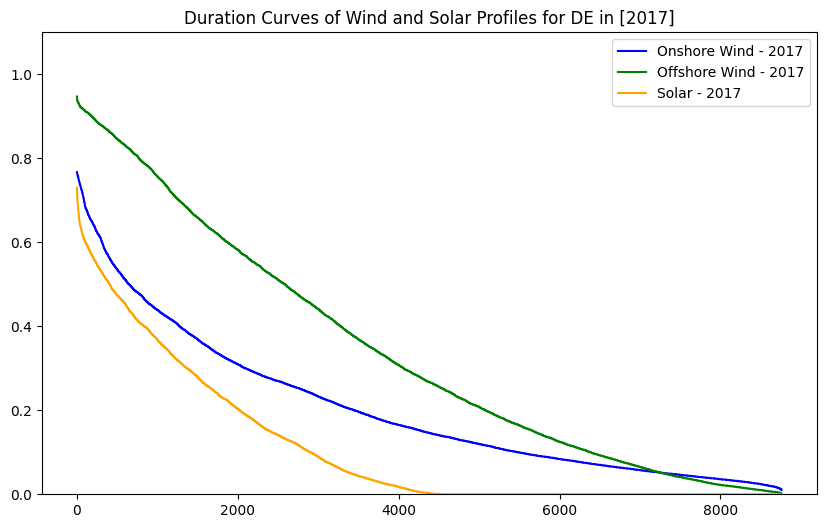

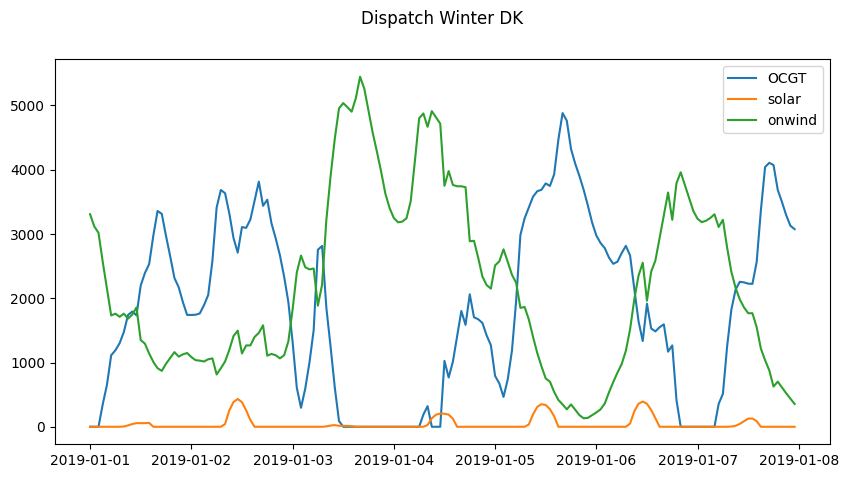

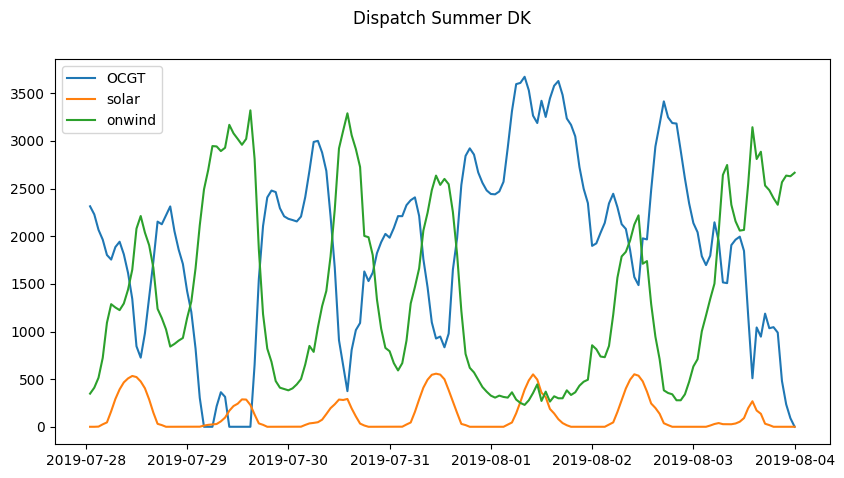

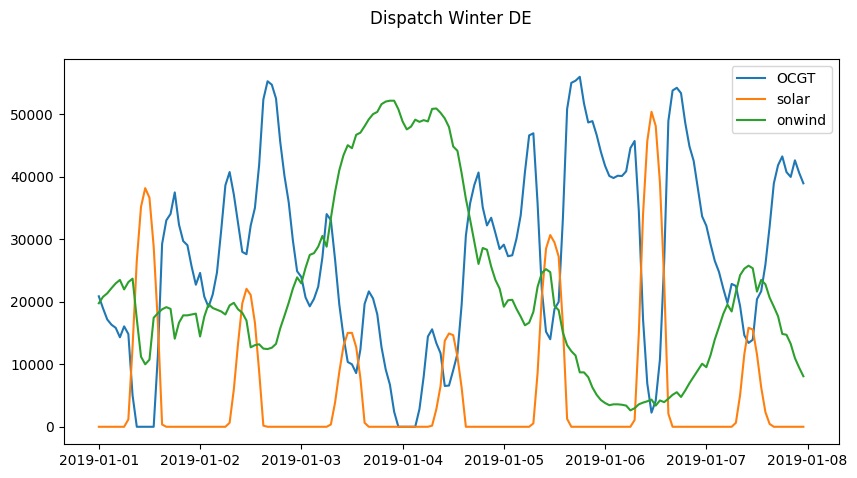

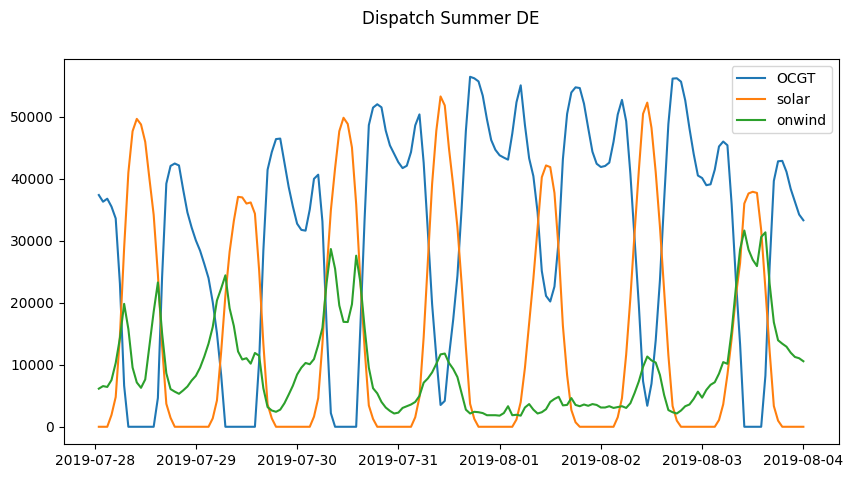

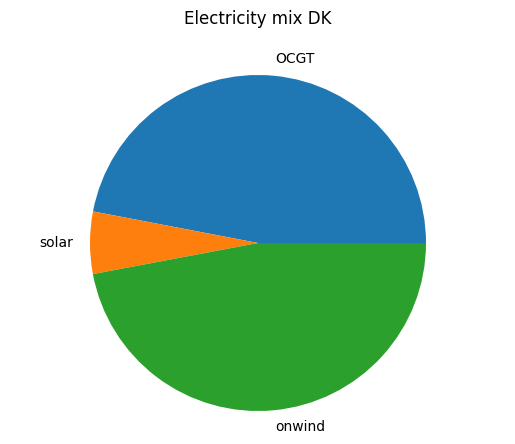

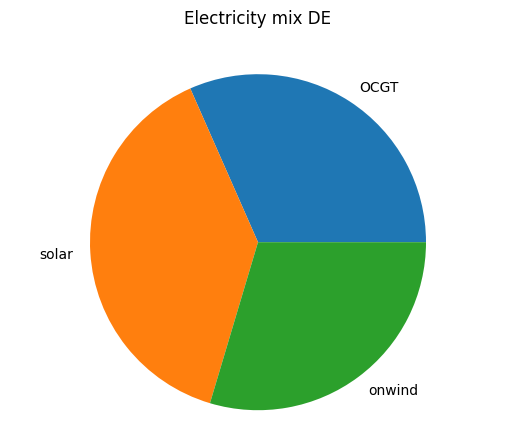

In [25]:
from PlotDispatch import PlotDispatch
from AnnualElectricityMix import AnnualElectricityMix
from DurationCurve import DurationCurve

region = 'DE'

years = [2017]

DurationCurve(years = years, region = region)

PlotDispatch(tmp)
AnnualElectricityMix(tmp)


# Task B

In [2]:
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
        'DE': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True,}
                # 'CCGT': True},
                }

setup.keys()


dict_keys(['DK', 'DE'])

In [4]:
generator_opt = {
    key: {
        'OCGT': [],
        'CCGT': [],
        'onwind': [],
        'solar': [] }
    for key in setup.keys()}

generator_opt

{'DK': {'OCGT': [], 'CCGT': [], 'onwind': [], 'solar': []},
 'DE': {'OCGT': [], 'CCGT': [], 'onwind': [], 'solar': []}}

Year 2019 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.


Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.77it/s]
INFO:linopy.io: Writing time: 1.04s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2617852


INFO:gurobipy:Set parameter LicenseID to value 2617852


Academic license - for non-commercial use only - expires 2026-02-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-04


Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-2wvt5ht1.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-2wvt5ht1.lp


Reading time = 0.30 seconds


INFO:gurobipy:Reading time = 0.30 seconds


obj: 157689 rows, 70088 columns, 289236 nonzeros


INFO:gurobipy:obj: 157689 rows, 70088 columns, 289236 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70088 primals, 157689 duals
Objective: 2.01e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2019 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.


Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s]
INFO:linopy.io: Writing time: 1.13s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2617852


INFO:gurobipy:Set parameter LicenseID to value 2617852


Academic license - for non-commercial use only - expires 2026-02-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-04


Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-gpglbr3e.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-gpglbr3e.lp


Reading time = 0.31 seconds


INFO:gurobipy:Reading time = 0.31 seconds


obj: 157689 rows, 70088 columns, 289236 nonzeros


INFO:gurobipy:obj: 157689 rows, 70088 columns, 289236 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70088 primals, 157689 duals
Objective: 1.62e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2019 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.


Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.01it/s]
INFO:linopy.io: Writing time: 1.21s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2617852


INFO:gurobipy:Set parameter LicenseID to value 2617852


Academic license - for non-commercial use only - expires 2026-02-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-04


Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-62vdw1ta.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-62vdw1ta.lp


Reading time = 0.46 seconds


INFO:gurobipy:Reading time = 0.46 seconds


obj: 157689 rows, 70088 columns, 289236 nonzeros


INFO:gurobipy:obj: 157689 rows, 70088 columns, 289236 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70088 primals, 157689 duals
Objective: 1.40e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2019 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.


Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s]
INFO:linopy.io: Writing time: 1.14s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2617852


INFO:gurobipy:Set parameter LicenseID to value 2617852


Academic license - for non-commercial use only - expires 2026-02-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-04


Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-gtudlcdo.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-gtudlcdo.lp


Reading time = 0.34 seconds


INFO:gurobipy:Reading time = 0.34 seconds


obj: 157689 rows, 70088 columns, 289236 nonzeros


INFO:gurobipy:obj: 157689 rows, 70088 columns, 289236 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70088 primals, 157689 duals
Objective: 1.24e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2019 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.


Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.06it/s]
INFO:linopy.io: Writing time: 1.15s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2617852


INFO:gurobipy:Set parameter LicenseID to value 2617852


Academic license - for non-commercial use only - expires 2026-02-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-04


Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-7y55kvpu.lp


INFO:gurobipy:Read LP format model from file C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\linopy-problem-7y55kvpu.lp


Reading time = 0.33 seconds


INFO:gurobipy:Reading time = 0.33 seconds


obj: 157689 rows, 70088 columns, 289236 nonzeros


INFO:gurobipy:obj: 157689 rows, 70088 columns, 289236 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70088 primals, 157689 duals
Objective: 1.12e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


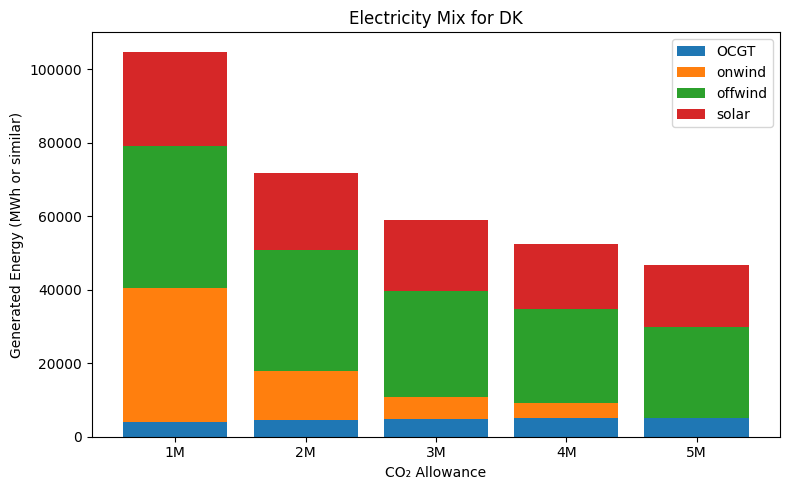

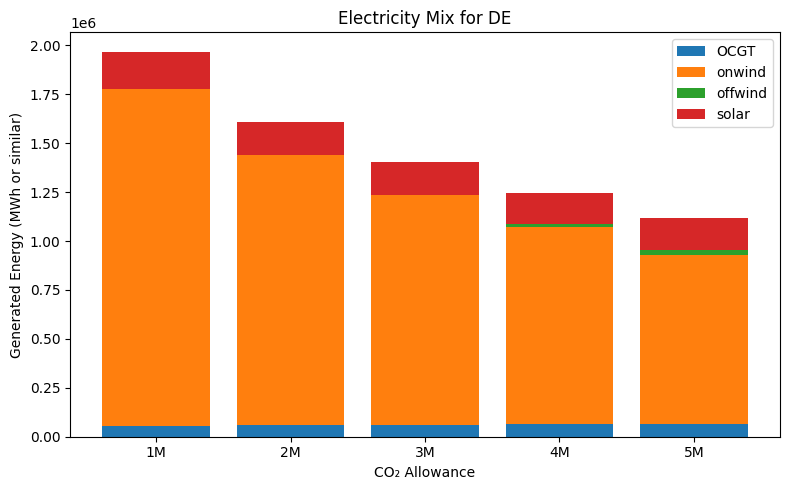

In [12]:
from NetworkB import NetworkB
import matplotlib.pyplot as plt
import numpy as np

CO2_limits = [1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000]
# CO2_limits = [1_000_000, 2_000_000]
generator_opt = {
    key: {
        'OCGT': [],
        'CCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

for CO2_limit in CO2_limits:
    tmp = NetworkB(setup = setup, cost_year = 2030, CO2_limit = CO2_limit)
    generators = tmp.network.generators.p_nom_opt.keys()
    for region in tmp.regions:
        for generator in generators:
            if generator.split(' ')[1] == region:
                generator_opt[region][generator.split(' ')[0]].append(tmp.network.generators.p_nom_opt[generator].sum())

x = np.arange(len(CO2_limits))  # [0, 1]

for country, techs in generator_opt.items():
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_limits))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, [f"{val//1_000_000}M" for val in CO2_limits])
    plt.title(f"Electricity Mix for {country}")
    plt.xlabel("CO₂ Allowance")
    plt.ylabel("Generated Energy (MWh or similar)")
    plt.legend()
    plt.tight_layout()
    plt.show()

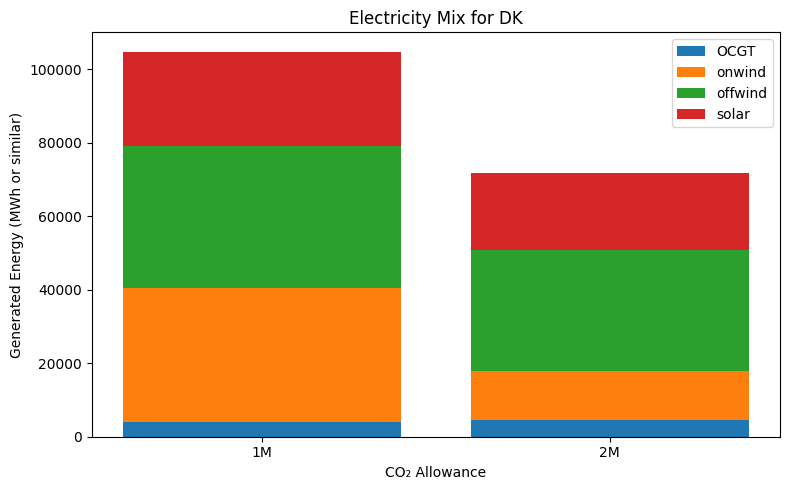

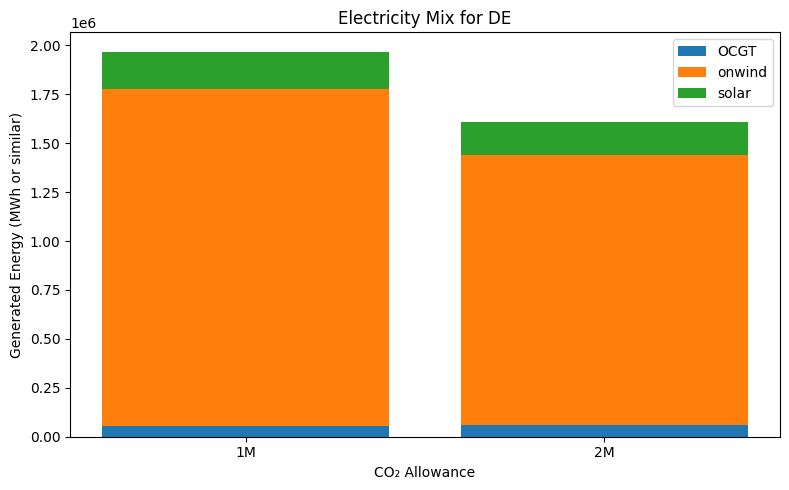

In [11]:
import numpy as np
import matplotlib.pyplot as plt

co2_levels = [1_000_000, 2_000_000]
x = np.arange(len(co2_levels))  # [0, 1]

for country, techs in generator_opt.items():
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(co2_levels))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, [f"{val//1_000_000}M" for val in co2_levels])
    plt.title(f"Electricity Mix for {country}")
    plt.xlabel("CO₂ Allowance")
    plt.ylabel("Generated Energy (MWh or similar)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
generator_opt

{'DK': {'OCGT': [4071.9947104894177, 4668.349988035779],
  'CCGT': [],
  'onwind': [36344.73082917612, 13119.096606339122],
  'offwind': [38826.74741791382, 33133.99244165069],
  'solar': [25558.171642709018, 20798.77832007141]},
 'DE': {'OCGT': [54362.28571428571, 58475.948651997125],
  'CCGT': [],
  'onwind': [1724476.1904761903, 1381670.9456669064],
  'offwind': [],
  'solar': [189171.5128529288, 169655.7584327821]}}

In [6]:
setup = {'DK_1': 
                            {'OCGT': True,
                            'CCGT': True,
                            'battery storage': True,
                            'onshore wind': True,
                            'solar': True},
        'DE':  {'OCGT': True,
                'CCGT': True,
                'battery storage': False,
                'onshore wind': True,
                'solar': True}}

In [7]:
import numpy as np
tmp.data_dict['DK']['Demand'].values.flatten()

array([3186.04, 3070.07, 2966.19, ..., 3438.26, 3309.25, 3315.91])

Det er noteret at:

In [ ]:
plt.plot(DataGeneration(year = 2019, region = 'DK_1').data['wind_offshore_generation_actual'].values)
plt.show()


Year 2018 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.
Year 2020 is greater than 2017, using data from last available year.


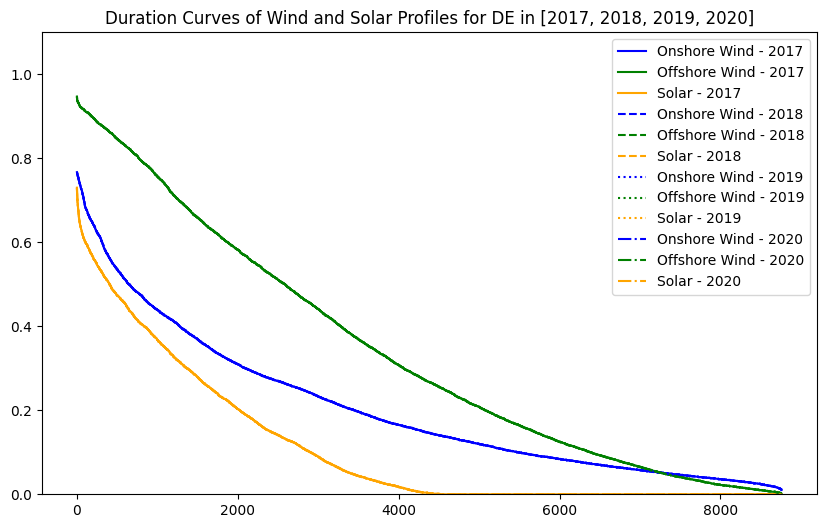

NameError: name 'plt' is not defined

In [ ]:
from DurationCurve import DurationCurve

# region = 'DK_1'
# region = 'DK_2'
# region = 'NO'
region = 'DE'

years = [2017, 2018, 2019, 2020]

DurationCurve(years = years, region = region)
plt.show()

# Testing plots 

# Task D

In [ ]:
# Basemodel with DK and DE
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
                }

tmp = BuildBaseNetwork(cost_year = 2030, setup = setup, demand_year=2019)